# Federated Learning Under the Lens of Task Arithmetic

This notebook runs all experiments for the project:
1. Centralized baseline training
2. FedAvg with IID/non-IID sharding
3. Sparse fine-tuning with task arithmetic
4. Mask strategy comparison (extension)

**Important**: This notebook is designed for Google Colab with GPU runtime.

## Setup

In [1]:
!git clone https://github.com/VitoFe/amlproject
%cd amlproject
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

fatal: il percorso di destinazione 'amlproject' esiste già e non è una directory vuota.
/home/fabio/Scrivania/PoliTo/II/Advanced/Vito's repo/amlproject
CUDA available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
# Install uv and dependencies
# !pip install --upgrade uv
# !uv sync

In [2]:
# Set checkpoint directory
CHECKPOINT_DIR = './fl_checkpoints'
LOG_DIR = './fl_logs'
# Import project modules
from src.data.dataset import get_cifar100_datasets, get_dataloaders
from src.models.dino_vit import create_dino_vit
from src.training.centralized import CentralizedTrainer
from src.training.federated import FederatedTrainer
from src.training.federated_sparse import FederatedSparseTrainer
from src.utils.seed import set_seed
from src.utils.logging import setup_logging
from src.utils.visualization import plot_training_curves, plot_comparison

## Configuration

In [3]:
# Experiment configuration
CONFIG = {
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_dir': './data',
    'checkpoint_dir': CHECKPOINT_DIR,
    'log_dir': LOG_DIR,
    
    # Data
    'batch_size': 64,
    'val_split': 0.1,
    
    # Centralized
    'centralized_epochs': 10,
    'centralized_lr': 1e-05,
    
    # Federated
    'num_clients': 100,       # K
    'participation_rate': 0.1, # C
    'local_steps': 4,          # J
    'num_rounds': 500,
    'federated_lr': 1e-04,
    
    # Non-IID
    'nc_values': [5, 10, 50], #nc = 1 already Done
    'j_values': [4, 8, 16],
    
    # Sparse
    'sparsity_ratio': 0.9,
    'calibration_rounds': 5,
    'fisher_samples': 512,
    
    # Multiple runs
    'num_runs': 3
}

print("Configuration loaded")
print(f"Device: {CONFIG['device']}")

Configuration loaded
Device: cuda


## Load Data

In [4]:
# Load CIFAR-100
set_seed(CONFIG['seed'])

train_dataset, val_dataset, test_dataset = get_cifar100_datasets(
    data_dir=CONFIG['data_dir'],
    val_split=CONFIG['val_split'],
    seed=CONFIG['seed']
)

train_loader, val_loader, test_loader = get_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=CONFIG['batch_size'],
    num_workers=2
)

print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Train: 45000 samples
Val: 5000 samples
Test: 10000 samples


## Experiment 1: Centralized Baseline

In [ ]:
# Uncomment to delete old checkpoints and start fresh
# import shutil, os
# shutil.rmtree(CHECKPOINT_DIR, ignore_errors=True)
# os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Create model with regularization
model = create_dino_vit(
    num_classes=100, 
    device=CONFIG['device'],
    dropout=0.3,
    freeze_layers=6
)
print(f"Model parameters: {model.count_parameters()}")

Using cache found in /home/fabio/.cache/torch/hub/facebookresearch_dino_main


Model parameters: {'total': 21704164, 'trainable': 10686052, 'frozen': 11018112}


In [18]:
 # Train centralized baseline
centralized_config = {
     'epochs': CONFIG['centralized_epochs'],
     'learning_rate': CONFIG['centralized_lr'],
     'momentum': 0.9,
     'weight_decay': 0.01,
     'scheduler': 'cosine',
     'label_smoothing': 0.1,
     'early_stopping_patience': 3,
     'checkpoint_dir': CHECKPOINT_DIR,
     'log_dir': LOG_DIR
 }
trainer = CentralizedTrainer(
     model=model,
     train_loader=train_loader,
     val_loader=val_loader,
     test_loader=test_loader,
     config=centralized_config,
     device=CONFIG['device'],
     experiment_name='centralized_regularized'
 )
 # (resume=False to start fresh, or True to continue)
centralized_results = trainer.train(resume=True, save_every=5)
print(f"\nCentralized Test Accuracy: {centralized_results['accuracy']:.4f}")

2026-01-29 01:33:29,204 | INFO | Starting centralized training for 10 epochs
2026-01-29 01:33:29,205 | INFO | Config: LR=1e-05, Momentum=0.9, Weight Decay=0.01, Scheduler=cosine
2026-01-29 01:33:29,205 | INFO | Early stopping enabled with patience=3


Epoch 0: 100%|██████████| 703/703 [01:56<00:00,  6.01it/s, loss=4.0562, acc=0.1896]


2026-01-29 01:35:32,496 | INFO | Step 0 | train_loss: 4.0562 | train_acc: 0.1896 | val_loss: 2.2802 | val_acc: 0.5366 | lr: 0.0000
2026-01-29 01:35:32,772 | INFO | New best validation accuracy: 0.5366


Epoch 1: 100%|██████████| 703/703 [01:57<00:00,  5.98it/s, loss=2.1940, acc=0.5676]


2026-01-29 01:37:36,611 | INFO | Step 1 | train_loss: 2.1940 | train_acc: 0.5676 | val_loss: 1.7609 | val_acc: 0.7002 | lr: 0.0000
2026-01-29 01:37:36,955 | INFO | New best validation accuracy: 0.7002
EarlyStopping: Metric improved to 0.7002


Epoch 2: 100%|██████████| 703/703 [01:57<00:00,  5.99it/s, loss=1.8326, acc=0.6809]


2026-01-29 01:39:40,725 | INFO | Step 2 | train_loss: 1.8326 | train_acc: 0.6809 | val_loss: 1.6218 | val_acc: 0.7408 | lr: 0.0000
2026-01-29 01:39:41,103 | INFO | New best validation accuracy: 0.7408
EarlyStopping: Metric improved to 0.7408


Epoch 3: 100%|██████████| 703/703 [01:58<00:00,  5.96it/s, loss=1.6847, acc=0.7288]


2026-01-29 01:41:45,548 | INFO | Step 3 | train_loss: 1.6847 | train_acc: 0.7288 | val_loss: 1.5537 | val_acc: 0.7586 | lr: 0.0000
2026-01-29 01:41:45,905 | INFO | New best validation accuracy: 0.7586
EarlyStopping: Metric improved to 0.7586


Epoch 4: 100%|██████████| 703/703 [01:59<00:00,  5.88it/s, loss=1.5966, acc=0.7599]


2026-01-29 01:43:51,962 | INFO | Step 4 | train_loss: 1.5966 | train_acc: 0.7599 | val_loss: 1.5094 | val_acc: 0.7746 | lr: 0.0000
2026-01-29 01:43:52,365 | INFO | New best validation accuracy: 0.7746
EarlyStopping: Metric improved to 0.7746


Epoch 5: 100%|██████████| 703/703 [02:00<00:00,  5.85it/s, loss=1.5416, acc=0.7774]


2026-01-29 01:45:59,294 | INFO | Step 5 | train_loss: 1.5416 | train_acc: 0.7774 | val_loss: 1.4837 | val_acc: 0.7864 | lr: 0.0000
2026-01-29 01:45:59,750 | INFO | New best validation accuracy: 0.7864
EarlyStopping: Metric improved to 0.7864


Epoch 6: 100%|██████████| 703/703 [02:00<00:00,  5.85it/s, loss=1.5019, acc=0.7905]


2026-01-29 01:48:06,666 | INFO | Step 6 | train_loss: 1.5019 | train_acc: 0.7905 | val_loss: 1.4633 | val_acc: 0.7938 | lr: 0.0000
2026-01-29 01:48:07,111 | INFO | New best validation accuracy: 0.7938
EarlyStopping: Metric improved to 0.7938


Epoch 7: 100%|██████████| 703/703 [01:58<00:00,  5.95it/s, loss=1.4771, acc=0.7982]


2026-01-29 01:50:12,064 | INFO | Step 7 | train_loss: 1.4771 | train_acc: 0.7982 | val_loss: 1.4538 | val_acc: 0.7934 | lr: 0.0000
EarlyStopping: No improvement for 1/3 epochs


Epoch 8: 100%|██████████| 703/703 [01:57<00:00,  5.97it/s, loss=1.4612, acc=0.8039]


2026-01-29 01:52:16,158 | INFO | Step 8 | train_loss: 1.4612 | train_acc: 0.8039 | val_loss: 1.4469 | val_acc: 0.7956 | lr: 0.0000
2026-01-29 01:52:16,533 | INFO | New best validation accuracy: 0.7956
EarlyStopping: Metric improved to 0.7956


Epoch 9: 100%|██████████| 703/703 [01:57<00:00,  5.99it/s, loss=1.4464, acc=0.8100]


2026-01-29 01:54:20,280 | INFO | Step 9 | train_loss: 1.4464 | train_acc: 0.8100 | val_loss: 1.4408 | val_acc: 0.7978 | lr: 0.0000
2026-01-29 01:54:20,663 | INFO | New best validation accuracy: 0.7978
EarlyStopping: Metric improved to 0.7978
2026-01-29 01:54:20,663 | INFO | Training complete. Evaluating on test set...


Evaluating: 100%|██████████| 157/157 [00:12<00:00, 12.33it/s]

2026-01-29 01:54:33,468 | INFO | Final Test Loss: 1.4398
2026-01-29 01:54:33,468 | INFO | Final Test Accuracy: 0.8017

Centralized Test Accuracy: 0.8017


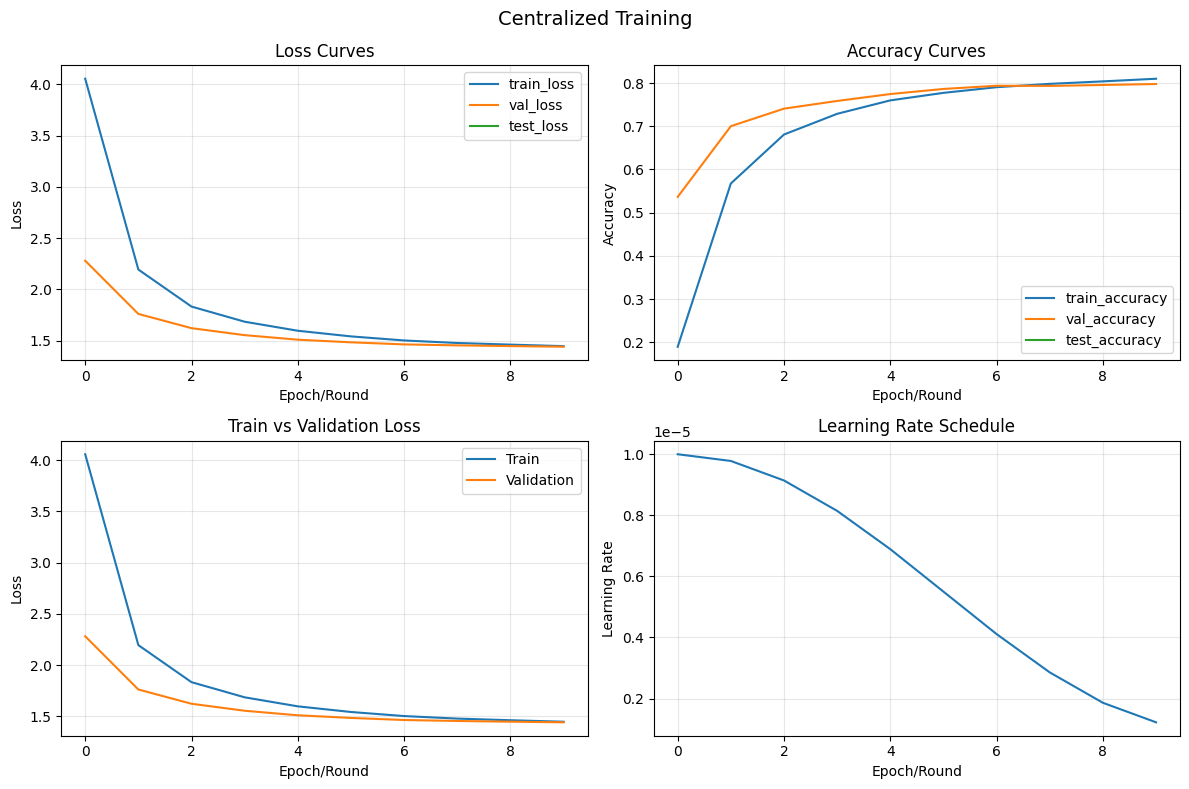

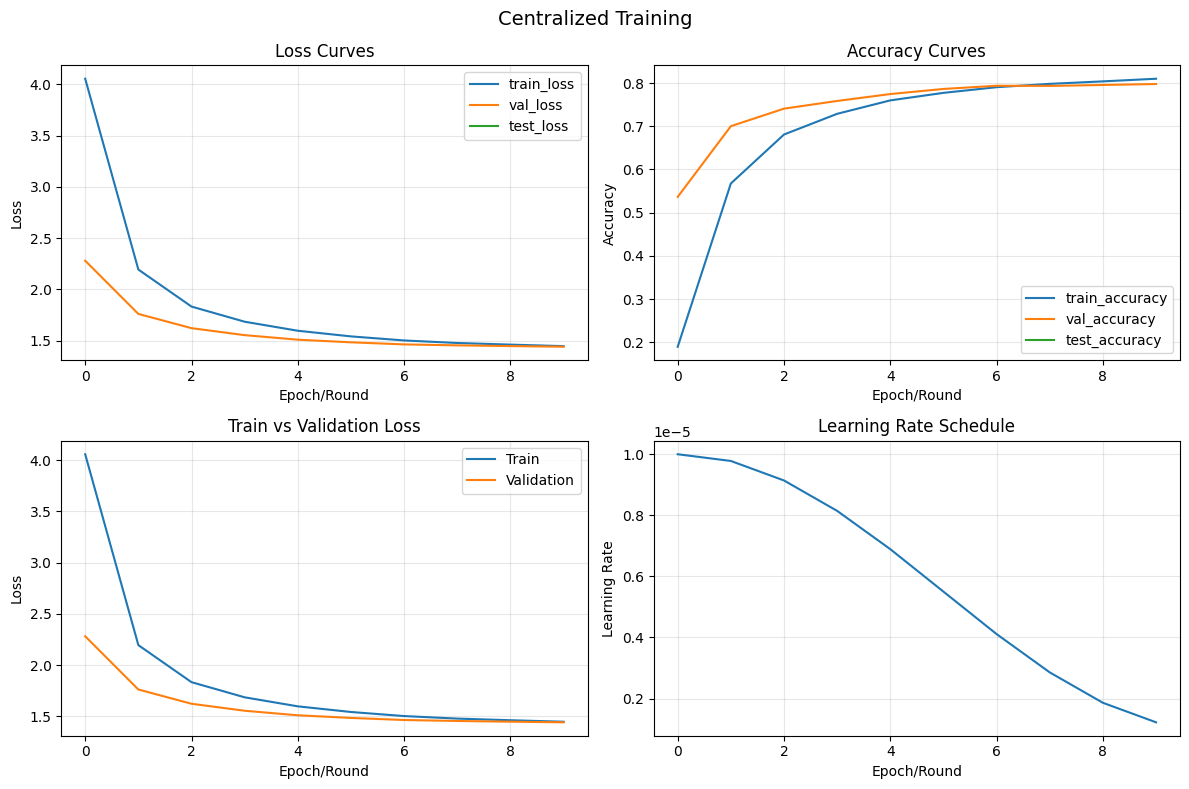

In [19]:
# Plot training curves
plot_training_curves(
     trainer.get_metrics_history(),
     title='Centralized Training',
     save_path=f"{CONFIG['log_dir']}/centralized_curves.png"
)

## Experiment 2: FedAvg with IID Sharding

In [9]:
# FedAvg with IID data distribution
set_seed(CONFIG['seed'])
model = create_dino_vit(num_classes=100, device=CONFIG['device'])

federated_config = {
    'num_clients': CONFIG['num_clients'],
    'participation_rate': CONFIG['participation_rate'],
    'local_steps': CONFIG['local_steps'],
    'num_rounds': CONFIG['num_rounds'],
    'learning_rate': CONFIG['federated_lr'],
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'early_stopping_patience': 3,
    'batch_size': CONFIG['batch_size'],
    'checkpoint_dir': CONFIG['checkpoint_dir'],
    'log_dir': CONFIG['log_dir'],
    'seed': CONFIG['seed'],
    'sharding': {'strategy': 'iid', 'nc': 100}
}

trainer = FederatedTrainer(
    model=model,
    train_dataset=train_dataset,
    val_loader=val_loader,
    test_loader=test_loader,
    config=federated_config,
    device=CONFIG['device'],
    experiment_name='fedavg_iid'
)

fedavg_iid_results = trainer.train(resume=False)
print(f"\nFedAvg (IID) Test Accuracy: {fedavg_iid_results['accuracy']:.4f}")

Using cache found in /home/fabio/.cache/torch/hub/facebookresearch_dino_main


2026-01-29 00:35:53,571 | INFO | Sharding statistics:
2026-01-29 00:35:53,572 | INFO |   - Samples per client: 450.0 ± 0.0
2026-01-29 00:35:53,572 | INFO |   - Classes per client: 99.0 ± 0.9
2026-01-29 00:35:53,572 | INFO | Federated Learning Setup:
2026-01-29 00:35:53,572 | INFO |   - Total clients (K): 100
2026-01-29 00:35:53,573 | INFO |   - Participation rate (C): 0.1
2026-01-29 00:35:53,573 | INFO |   - Clients per round: 10
2026-01-29 00:35:53,574 | INFO |   - Local steps (J): 4
2026-01-29 00:35:53,574 | INFO |   - Learning rate: 0.0001 (scheduler: cosine)
2026-01-29 00:35:53,574 | INFO |   - Sharding: iid
2026-01-29 00:35:53,574 | INFO |   - Mixed precision (AMP): True
2026-01-29 00:35:53,574 | INFO |   - Early stopping patience: 3 rounds
2026-01-29 00:35:53,575 | INFO | Starting federated training for 500 rounds


/home/fabio/Scrivania/PoliTo/II/Advanced/Vito's repo/amlproject/src/training/federated.py:113: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if self.use_amp else None
Round 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/fabio/Scrivania/PoliTo/II/Advanced/Vito's repo/amlproject/src/training/federated.py:282: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


2026-01-29 00:36:06,127 | INFO | Step 0 | train_loss: 6.2983 | train_acc: 0.0129 | val_loss: 5.8228 | val_acc: 0.0148 | lr: 0.0001
2026-01-29 00:36:06,329 | INFO | Round 0: New best val accuracy: 0.0148


2026-01-29 00:37:12,772 | INFO | Round 10: New best val accuracy: 0.0494
EarlyStopping: Metric improved to 0.0494


2026-01-29 00:38:19,521 | INFO | Round 20: New best val accuracy: 0.0918
EarlyStopping: Metric improved to 0.0918


2026-01-29 00:39:26,011 | INFO | Round 30: New best val accuracy: 0.1458
EarlyStopping: Metric improved to 0.1458


2026-01-29 00:40:31,678 | INFO | Round 40: New best val accuracy: 0.2242
EarlyStopping: Metric improved to 0.2242


2026-01-29 00:41:37,429 | INFO | Round 50: New best val accuracy: 0.3030
EarlyStopping: Metric improved to 0.3030


2026-01-29 00:42:43,450 | INFO | Round 60: New best val accuracy: 0.3734
EarlyStopping: Metric improved to 0.3734


2026-01-29 00:43:49,445 | INFO | Round 70: New best val accuracy: 0.4486
EarlyStopping: Metric improved to 0.4486


2026-01-29 00:44:58,526 | INFO | Round 80: New best val accuracy: 0.5018
EarlyStopping: Metric improved to 0.5018


2026-01-29 00:46:04,888 | INFO | Round 90: New best val accuracy: 0.5476
EarlyStopping: Metric improved to 0.5476


2026-01-29 00:47:12,045 | INFO | Round 100: New best val accuracy: 0.5684
EarlyStopping: Metric improved to 0.5684


2026-01-29 00:48:19,273 | INFO | Round 110: New best val accuracy: 0.6172
EarlyStopping: Metric improved to 0.6172


2026-01-29 00:49:25,129 | INFO | Round 120: New best val accuracy: 0.6296
EarlyStopping: Metric improved to 0.6296


2026-01-29 00:50:31,821 | INFO | Round 130: New best val accuracy: 0.6638
EarlyStopping: Metric improved to 0.6638


2026-01-29 00:51:38,498 | INFO | Round 140: New best val accuracy: 0.6718
EarlyStopping: Metric improved to 0.6718


2026-01-29 00:52:44,540 | INFO | Round 150: New best val accuracy: 0.6896
EarlyStopping: Metric improved to 0.6896


2026-01-29 00:53:49,884 | INFO | Round 160: New best val accuracy: 0.6960
EarlyStopping: Metric improved to 0.6960


2026-01-29 00:54:55,567 | INFO | Round 170: New best val accuracy: 0.7128
EarlyStopping: Metric improved to 0.7128


2026-01-29 00:56:01,402 | INFO | Round 180: New best val accuracy: 0.7240
EarlyStopping: Metric improved to 0.7240


2026-01-29 00:57:07,026 | INFO | Round 190: New best val accuracy: 0.7312
EarlyStopping: Metric improved to 0.7312


2026-01-29 00:58:12,611 | INFO | Round 200: New best val accuracy: 0.7358
EarlyStopping: Metric improved to 0.7358


2026-01-29 00:59:18,103 | INFO | Round 210: New best val accuracy: 0.7384
EarlyStopping: Metric improved to 0.7384


2026-01-29 01:00:23,953 | INFO | Round 220: New best val accuracy: 0.7506
EarlyStopping: Metric improved to 0.7506


2026-01-29 01:01:29,574 | INFO | Round 230: New best val accuracy: 0.7512
EarlyStopping: No improvement for 1/3 epochs


2026-01-29 01:02:35,655 | INFO | Round 240: New best val accuracy: 0.7542
EarlyStopping: Metric improved to 0.7542


2026-01-29 01:03:41,403 | INFO | Round 250: New best val accuracy: 0.7580
EarlyStopping: Metric improved to 0.7580


2026-01-29 01:04:46,355 | INFO | Round 260: New best val accuracy: 0.7624
EarlyStopping: Metric improved to 0.7624


2026-01-29 01:05:51,393 | INFO | Round 270: New best val accuracy: 0.7668
EarlyStopping: Metric improved to 0.7668


EarlyStopping: No improvement for 1/3 epochs


2026-01-29 01:08:00,783 | INFO | Round 290: New best val accuracy: 0.7756
EarlyStopping: Metric improved to 0.7756


EarlyStopping: No improvement for 1/3 epochs


EarlyStopping: No improvement for 2/3 epochs


2026-01-29 01:11:14,763 | INFO | Round 320: New best val accuracy: 0.7792
EarlyStopping: Metric improved to 0.7792


2026-01-29 01:12:20,555 | INFO | Round 330: New best val accuracy: 0.7794
EarlyStopping: No improvement for 1/3 epochs


2026-01-29 01:13:27,599 | INFO | Round 340: New best val accuracy: 0.7804
EarlyStopping: Metric improved to 0.7804


2026-01-29 01:14:35,094 | INFO | Round 350: New best val accuracy: 0.7822
EarlyStopping: Metric improved to 0.7822


2026-01-29 01:15:42,358 | INFO | Round 360: New best val accuracy: 0.7846
EarlyStopping: Metric improved to 0.7846


2026-01-29 01:16:48,526 | INFO | Round 370: New best val accuracy: 0.7852
EarlyStopping: No improvement for 1/3 epochs


EarlyStopping: No improvement for 2/3 epochs


2026-01-29 01:18:54,644 | INFO | Round 390: New best val accuracy: 0.7864
EarlyStopping: Metric improved to 0.7864


2026-01-29 01:19:57,372 | INFO | Round 400: New best val accuracy: 0.7878
EarlyStopping: Metric improved to 0.7878


EarlyStopping: No improvement for 1/3 epochs


EarlyStopping: No improvement for 2/3 epochs


EarlyStopping: No improvement for 3/3 epochs
EarlyStopping: Stopping! Best was 0.7878 at epoch 400
2026-01-29 01:23:04,340 | INFO | Early stopping triggered at round 430!
2026-01-29 01:23:04,341 | INFO | Best validation accuracy was 0.7878 at round 400
2026-01-29 01:23:04,341 | INFO | Training complete. Evaluating on test set...


Evaluating: 100%|██████████| 157/157 [00:12<00:00, 12.52it/s]

2026-01-29 01:23:16,950 | INFO | Final Test Loss: 1.5171
2026-01-29 01:23:16,950 | INFO | Final Test Accuracy: 0.7828

FedAvg (IID) Test Accuracy: 0.7828


In [ ]:
print(trainer.get_metrics_history())
#{'train_loss': [6.298293280601501, 4.627954161167144, 4.294315254688263, 4.016945189237594, 3.6482975482940674, 3.2969304859638213, 2.971794146299362, 2.7246610522270203, 2.527439612150192, 2.348067635297775, 2.2532349646091463, 2.1342486679553985, 1.9682571470737458, 1.9590494155883789, 1.8801251590251922, 1.827480036020279, 1.8581959813833238, 1.7550791680812836, 1.707242450118065, 1.740210872888565, 1.692002311348915, 1.6590333580970764, 1.6223743855953217, 1.6427214086055755, 1.5987949818372726, 1.5821866035461425, 1.5691515117883683, 1.5446060657501222, 1.5402734339237214, 1.5123868703842163, 1.4848422139883042, 1.5003162354230881, 1.5186016589403153, 1.499525547027588, 1.4612892776727677, 1.4943918645381928, 1.447961163520813, 1.4962108582258224, 1.4739391177892684, 1.4786529958248138, 1.5017278075218201, 1.4492209911346436, 1.4645843476057052, 1.476788380742073], 'train_accuracy': [0.012890625, 0.0328125, 0.071875, 0.112890625, 0.19140625, 0.27109375, 0.3421875, 0.399609375, 0.451171875, 0.519140625, 0.5359375, 0.58515625, 0.6265625, 0.630859375, 0.66171875, 0.6703125, 0.666796875, 0.703125, 0.726171875, 0.705859375, 0.73359375, 0.73828125, 0.75, 0.736328125, 0.759375, 0.76953125, 0.768359375, 0.77421875, 0.778515625, 0.794140625, 0.80078125, 0.787109375, 0.78828125, 0.788671875, 0.81640625, 0.8015625, 0.823046875, 0.794140625, 0.805078125, 0.809765625, 0.7921875, 0.812109375, 0.812890625, 0.801171875], 'val_loss': [5.822758772277832, 4.462991134643555, 4.189966967010498, 3.8795170032501223, 3.4766042327880857, 3.133977293014526, 2.8264029487609865, 2.560017692565918, 2.362293390274048, 2.200119253158569, 2.1266552602767943, 1.993629626274109, 1.9361465854644775, 1.8619416835784912, 1.8221237277984619, 1.7807487243652345, 1.7545053537368775, 1.7169194023132324, 1.6954067291259765, 1.6709712413787843, 1.6502965406417847, 1.636363868522644, 1.6198414388656617, 1.6095373218536377, 1.5930169450759888, 1.5847841413497925, 1.5725706466674805, 1.5666970825195312, 1.5576661800384521, 1.5513988430023193, 1.5421443849563599, 1.5379411792755127, 1.531881883239746, 1.5291576038360595, 1.523099774169922, 1.5213431346893311, 1.5194377910614014, 1.5148132575988769, 1.5131930576324464, 1.5111685468673706, 1.5092163709640503, 1.5085638885498047, 1.5061099952697754, 1.5054684329986572], 'val_accuracy': [0.0148, 0.0494, 0.0918, 0.1458, 0.2242, 0.303, 0.3734, 0.4486, 0.5018, 0.5476, 0.5684, 0.6172, 0.6296, 0.6638, 0.6718, 0.6896, 0.696, 0.7128, 0.724, 0.7312, 0.7358, 0.7384, 0.7506, 0.7512, 0.7542, 0.758, 0.7624, 0.7668, 0.7662, 0.7756, 0.7724, 0.7742, 0.7792, 0.7794, 0.7804, 0.7822, 0.7846, 0.7852, 0.7822, 0.7864, 0.7878, 0.785, 0.7872, 0.786], 'test_loss': [1.51709850025177], 'test_accuracy': [0.7828], 'learning_rate': [0.0001, 9.990193130362149e-05, 9.960811379910043e-05, 9.91197117005638e-05, 9.843866023860196e-05, 9.756765799216607e-05, 9.651015619579555e-05, 9.52703450645445e-05, 9.385313719079255e-05, 9.226414807872868e-05, 9.050967389363694e-05, 8.859666651415007e-05, 8.65327059863234e-05, 8.432597048867577e-05, 8.19852039272074e-05, 7.951968128879548e-05, 7.693917189024973e-05, 7.425390066864924e-05, 7.147450766634252e-05, 6.861200587114613e-05, 6.567773757879485e-05, 6.268332945055154e-05, 5.964064644405507e-05, 5.656174479994948e-05, 5.3458824270578844e-05, 5.034417978003533e-05, 4.7230152707101555e-05, 4.412908198412218e-05, 4.1053255205569135e-05, 3.801485994002661e-05, 3.502593543851579e-05, 3.209832493050891e-05, 2.9243628696653363e-05, 2.647315810414963e-05, 2.3797890786911288e-05, 2.1228427148100626e-05, 1.877494835739236e-05, 1.6447176009396504e-05, 1.425433360308815e-05, 1.2205109994877399e-05, 1.0307624970131763e-05, 8.569397069569382e-06, 6.99731379800712e-06, 5.597604333507218e-06]}


{'train_loss': [6.298293280601501, 4.627954161167144, 4.294315254688263, 4.016945189237594, 3.6482975482940674, 3.2969304859638213, 2.971794146299362, 2.7246610522270203, 2.527439612150192, 2.348067635297775, 2.2532349646091463, 2.1342486679553985, 1.9682571470737458, 1.9590494155883789, 1.8801251590251922, 1.827480036020279, 1.8581959813833238, 1.7550791680812836, 1.707242450118065, 1.740210872888565, 1.692002311348915, 1.6590333580970764, 1.6223743855953217, 1.6427214086055755, 1.5987949818372726, 1.5821866035461425, 1.5691515117883683, 1.5446060657501222, 1.5402734339237214, 1.5123868703842163, 1.4848422139883042, 1.5003162354230881, 1.5186016589403153, 1.499525547027588, 1.4612892776727677, 1.4943918645381928, 1.447961163520813, 1.4962108582258224, 1.4739391177892684, 1.4786529958248138, 1.5017278075218201, 1.4492209911346436, 1.4645843476057052, 1.476788380742073], 'train_accuracy': [0.012890625, 0.0328125, 0.071875, 0.112890625, 0.19140625, 0.27109375, 0.3421875, 0.399609375, 0.4

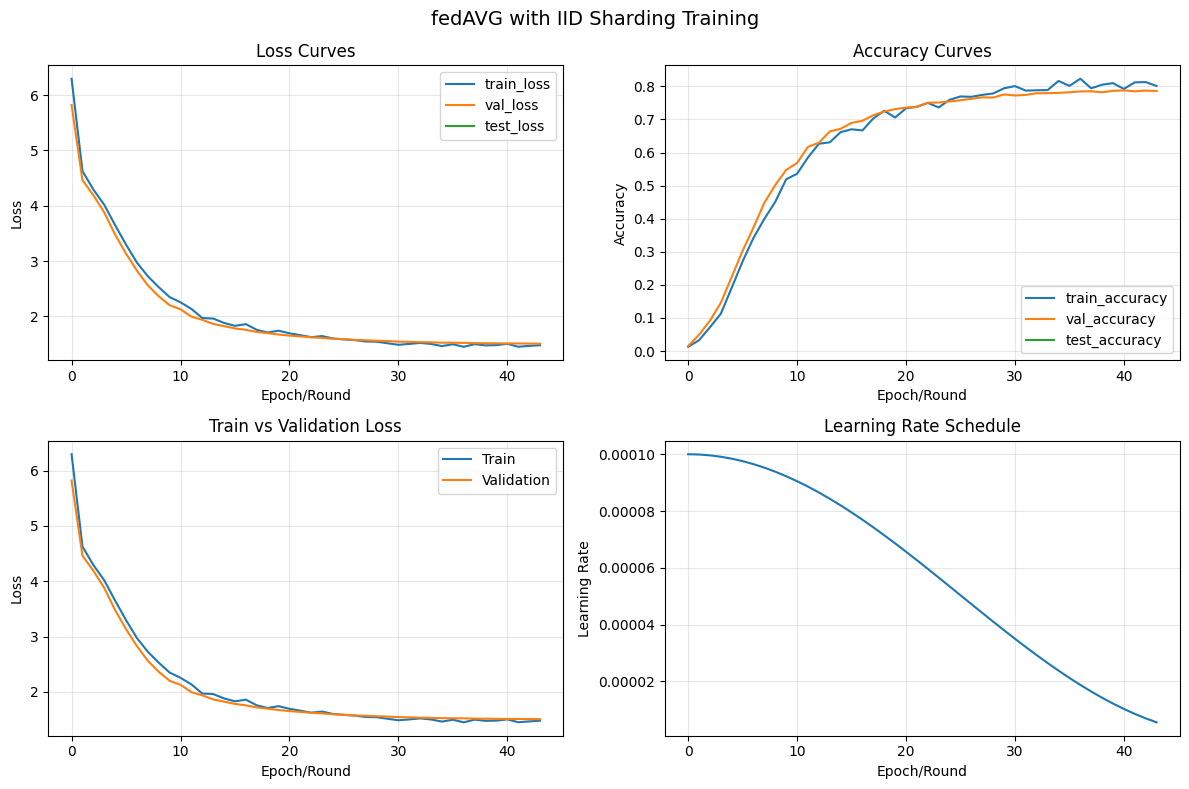

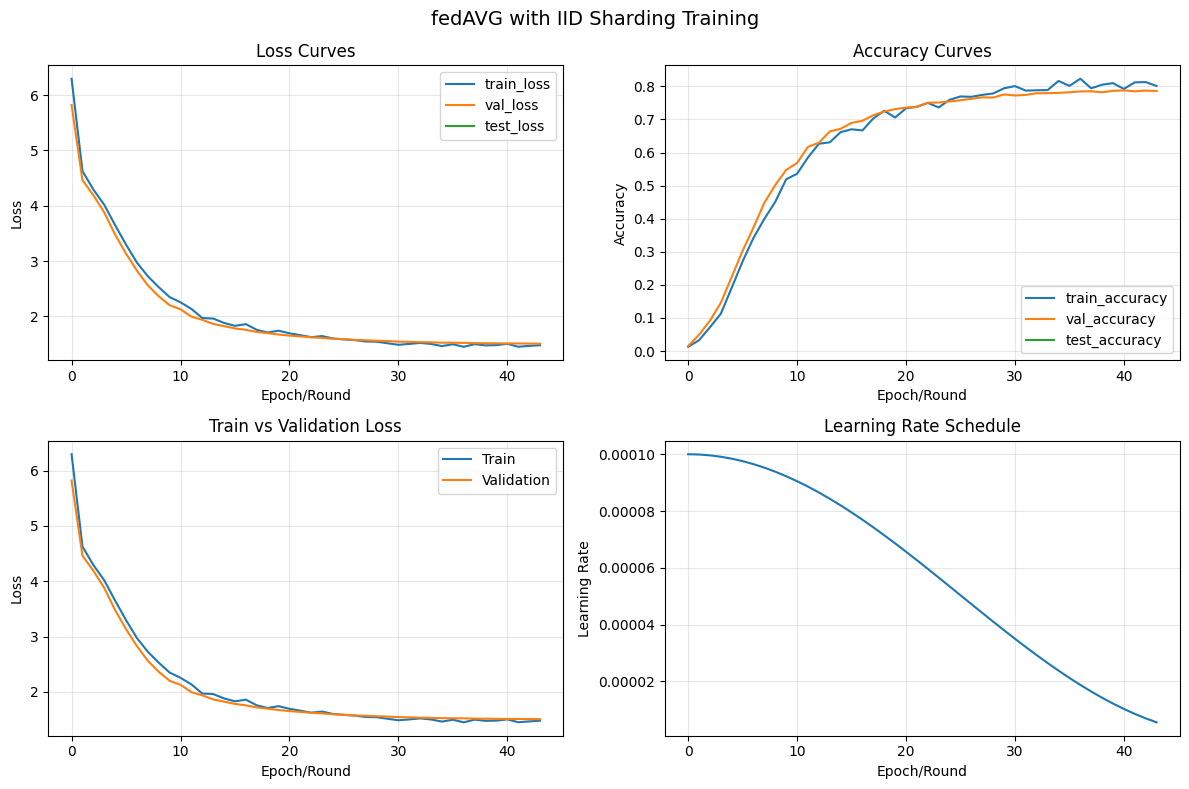

In [11]:
# Plot training curves
plot_training_curves(
    trainer.get_metrics_history(),
    title='fedAVG with IID Sharding Training',
    save_path=f"{CONFIG['log_dir']}/IID_curves.png"
)

## Experiment 3: FedAvg with Non-IID Sharding (Varying Nc)


Testing Nc = 5 classes per client


Using cache found in /home/fabio/.cache/torch/hub/facebookresearch_dino_main


2026-01-29 10:34:12,260 | INFO | Sharding statistics:
2026-01-29 10:34:12,260 | INFO |   - Samples per client: 448.1 ± 11.0
2026-01-29 10:34:12,260 | INFO |   - Classes per client: 5.0 ± 0.0
2026-01-29 10:34:12,261 | INFO | Federated Learning Setup:
2026-01-29 10:34:12,261 | INFO |   - Total clients (K): 100
2026-01-29 10:34:12,261 | INFO |   - Participation rate (C): 0.1
2026-01-29 10:34:12,261 | INFO |   - Clients per round: 10
2026-01-29 10:34:12,261 | INFO |   - Local steps (J): 4
2026-01-29 10:34:12,262 | INFO |   - Learning rate: 0.0001 (scheduler: cosine)
2026-01-29 10:34:12,262 | INFO |   - Sharding: non_iid
2026-01-29 10:34:12,262 | INFO |   - Mixed precision (AMP): True
2026-01-29 10:34:12,262 | INFO |   - Classes per client (Nc): 5
2026-01-29 10:34:12,262 | INFO |   - Early stopping patience: 20 rounds
2026-01-29 10:34:12,262 | INFO | Starting federated training for 500 rounds


/home/fabio/Scrivania/PoliTo/II/Advanced/Vito's repo/amlproject/src/training/federated.py:113: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if self.use_amp else None
Round 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/fabio/Scrivania/PoliTo/II/Advanced/Vito's repo/amlproject/src/training/federated.py:282: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


2026-01-29 10:34:24,927 | INFO | Step 0 | train_loss: 5.0010 | train_acc: 0.1148 | val_loss: 5.9110 | val_acc: 0.0108 | lr: 0.0001
2026-01-29 10:34:25,181 | INFO | Round 0: New best val accuracy: 0.0108


2026-01-29 10:35:28,625 | INFO | Round 10: New best val accuracy: 0.0360
EarlyStopping: Metric improved to 0.0360


2026-01-29 10:36:32,010 | INFO | Round 20: New best val accuracy: 0.0368
EarlyStopping: Metric improved to 0.0368


2026-01-29 10:37:35,346 | INFO | Round 30: New best val accuracy: 0.0678
EarlyStopping: Metric improved to 0.0678


2026-01-29 10:38:39,031 | INFO | Round 40: New best val accuracy: 0.0852
EarlyStopping: Metric improved to 0.0852


2026-01-29 10:39:42,134 | INFO | Round 50: New best val accuracy: 0.1252
EarlyStopping: Metric improved to 0.1252


2026-01-29 10:40:43,372 | INFO | Round 60: New best val accuracy: 0.1502
EarlyStopping: Metric improved to 0.1502


2026-01-29 10:41:44,769 | INFO | Round 70: New best val accuracy: 0.1856
EarlyStopping: Metric improved to 0.1856


2026-01-29 10:42:46,115 | INFO | Round 80: New best val accuracy: 0.1944
EarlyStopping: Metric improved to 0.1944


2026-01-29 10:43:47,557 | INFO | Round 90: New best val accuracy: 0.2240
EarlyStopping: Metric improved to 0.2240


2026-01-29 10:44:49,058 | INFO | Round 100: New best val accuracy: 0.2806
EarlyStopping: Metric improved to 0.2806


2026-01-29 10:45:50,470 | INFO | Round 110: New best val accuracy: 0.2890
EarlyStopping: Metric improved to 0.2890


2026-01-29 10:46:51,971 | INFO | Round 120: New best val accuracy: 0.3558
EarlyStopping: Metric improved to 0.3558


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 10:48:54,659 | INFO | Round 140: New best val accuracy: 0.4150
EarlyStopping: Metric improved to 0.4150


2026-01-29 10:49:56,031 | INFO | Round 150: New best val accuracy: 0.4368
EarlyStopping: Metric improved to 0.4368


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 10:51:58,686 | INFO | Round 170: New best val accuracy: 0.4522
EarlyStopping: Metric improved to 0.4522


2026-01-29 10:53:01,748 | INFO | Round 180: New best val accuracy: 0.4670
EarlyStopping: Metric improved to 0.4670


2026-01-29 10:54:05,408 | INFO | Round 190: New best val accuracy: 0.5096
EarlyStopping: Metric improved to 0.5096


2026-01-29 10:55:10,492 | INFO | Round 200: New best val accuracy: 0.5188
EarlyStopping: Metric improved to 0.5188


2026-01-29 10:56:14,729 | INFO | Round 210: New best val accuracy: 0.5532
EarlyStopping: Metric improved to 0.5532


2026-01-29 10:57:17,717 | INFO | Round 220: New best val accuracy: 0.5638
EarlyStopping: Metric improved to 0.5638


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 10:59:25,437 | INFO | Round 240: New best val accuracy: 0.5752
EarlyStopping: Metric improved to 0.5752


2026-01-29 11:00:29,549 | INFO | Round 250: New best val accuracy: 0.5978
EarlyStopping: Metric improved to 0.5978


2026-01-29 11:01:33,447 | INFO | Round 260: New best val accuracy: 0.6094
EarlyStopping: Metric improved to 0.6094


EarlyStopping: No improvement for 1/20 epochs


EarlyStopping: No improvement for 2/20 epochs


2026-01-29 11:04:44,301 | INFO | Round 290: New best val accuracy: 0.6238
EarlyStopping: Metric improved to 0.6238


2026-01-29 11:05:47,771 | INFO | Round 300: New best val accuracy: 0.6382
EarlyStopping: Metric improved to 0.6382


2026-01-29 11:06:51,243 | INFO | Round 310: New best val accuracy: 0.6506
EarlyStopping: Metric improved to 0.6506


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 11:08:57,774 | INFO | Round 330: New best val accuracy: 0.6598
EarlyStopping: Metric improved to 0.6598


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 11:11:02,517 | INFO | Round 350: New best val accuracy: 0.6728
EarlyStopping: Metric improved to 0.6728


2026-01-29 11:12:04,087 | INFO | Round 360: New best val accuracy: 0.6734
EarlyStopping: Metric improved to 0.6734


2026-01-29 11:13:05,727 | INFO | Round 370: New best val accuracy: 0.6762
EarlyStopping: Metric improved to 0.6762


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 11:15:13,192 | INFO | Round 390: New best val accuracy: 0.6772
EarlyStopping: Metric improved to 0.6772


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 11:17:21,238 | INFO | Round 410: New best val accuracy: 0.6860
EarlyStopping: Metric improved to 0.6860


2026-01-29 11:18:27,708 | INFO | Round 420: New best val accuracy: 0.6902
EarlyStopping: Metric improved to 0.6902


EarlyStopping: No improvement for 1/20 epochs


EarlyStopping: No improvement for 2/20 epochs


2026-01-29 11:21:41,171 | INFO | Round 450: New best val accuracy: 0.6932
EarlyStopping: Metric improved to 0.6932


2026-01-29 11:22:46,786 | INFO | Round 460: New best val accuracy: 0.6938
EarlyStopping: Metric improved to 0.6938


2026-01-29 11:23:51,340 | INFO | Round 470: New best val accuracy: 0.6950
EarlyStopping: Metric improved to 0.6950


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 11:25:59,219 | INFO | Round 490: New best val accuracy: 0.6964
EarlyStopping: Metric improved to 0.6964


2026-01-29 11:26:57,331 | INFO | Step 499 | train_loss: 1.6430 | train_acc: 0.7471 | val_loss: 1.7440 | val_acc: 0.6966 | lr: 0.0000
2026-01-29 11:26:57,627 | INFO | Round 499: New best val accuracy: 0.6966
EarlyStopping: Metric improved to 0.6966
2026-01-29 11:26:57,628 | INFO | Training complete. Evaluating on test set...


Evaluating: 100%|██████████| 157/157 [00:12<00:00, 12.42it/s]

2026-01-29 11:27:10,330 | INFO | Final Test Loss: 1.7530
2026-01-29 11:27:10,330 | INFO | Final Test Accuracy: 0.7001


Nc=5: Test Accuracy = 0.7001

Testing Nc = 10 classes per client


Using cache found in /home/fabio/.cache/torch/hub/facebookresearch_dino_main


2026-01-29 11:27:11,003 | INFO | Sharding statistics:
2026-01-29 11:27:11,004 | INFO |   - Samples per client: 445.7 ± 12.7
2026-01-29 11:27:11,004 | INFO |   - Classes per client: 10.0 ± 0.0
2026-01-29 11:27:11,004 | INFO | Federated Learning Setup:
2026-01-29 11:27:11,004 | INFO |   - Total clients (K): 100
2026-01-29 11:27:11,004 | INFO |   - Participation rate (C): 0.1
2026-01-29 11:27:11,005 | INFO |   - Clients per round: 10
2026-01-29 11:27:11,005 | INFO |   - Local steps (J): 4
2026-01-29 11:27:11,006 | INFO |   - Learning rate: 0.0001 (scheduler: cosine)
2026-01-29 11:27:11,006 | INFO |   - Sharding: non_iid
2026-01-29 11:27:11,006 | INFO |   - Mixed precision (AMP): True
2026-01-29 11:27:11,007 | INFO |   - Classes per client (Nc): 10
2026-01-29 11:27:11,007 | INFO |   - Early stopping patience: 20 rounds
2026-01-29 11:27:11,009 | INFO | Starting federated training for 500 rounds


2026-01-29 11:27:23,456 | INFO | Step 0 | train_loss: 5.4394 | train_acc: 0.0592 | val_loss: 5.8460 | val_acc: 0.0144 | lr: 0.0001
2026-01-29 11:27:23,650 | INFO | Round 0: New best val accuracy: 0.0144


2026-01-29 11:28:27,449 | INFO | Round 10: New best val accuracy: 0.0350
EarlyStopping: Metric improved to 0.0350


2026-01-29 11:29:30,490 | INFO | Round 20: New best val accuracy: 0.0786
EarlyStopping: Metric improved to 0.0786


2026-01-29 11:30:33,712 | INFO | Round 30: New best val accuracy: 0.1066
EarlyStopping: Metric improved to 0.1066


2026-01-29 11:31:37,569 | INFO | Round 40: New best val accuracy: 0.2128
EarlyStopping: Metric improved to 0.2128


2026-01-29 11:32:43,474 | INFO | Round 50: New best val accuracy: 0.2574
EarlyStopping: Metric improved to 0.2574


2026-01-29 11:33:48,922 | INFO | Round 60: New best val accuracy: 0.3522
EarlyStopping: Metric improved to 0.3522


2026-01-29 11:34:54,118 | INFO | Round 70: New best val accuracy: 0.3798
EarlyStopping: Metric improved to 0.3798


2026-01-29 11:36:01,195 | INFO | Round 80: New best val accuracy: 0.4512
EarlyStopping: Metric improved to 0.4512


2026-01-29 11:37:07,430 | INFO | Round 90: New best val accuracy: 0.5030
EarlyStopping: Metric improved to 0.5030


2026-01-29 11:38:13,471 | INFO | Round 100: New best val accuracy: 0.5270
EarlyStopping: Metric improved to 0.5270


2026-01-29 11:39:19,432 | INFO | Round 110: New best val accuracy: 0.5814
EarlyStopping: Metric improved to 0.5814


2026-01-29 11:40:25,426 | INFO | Round 120: New best val accuracy: 0.6022
EarlyStopping: Metric improved to 0.6022


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 11:42:32,331 | INFO | Round 140: New best val accuracy: 0.6240
EarlyStopping: Metric improved to 0.6240


2026-01-29 11:43:34,058 | INFO | Round 150: New best val accuracy: 0.6420
EarlyStopping: Metric improved to 0.6420


2026-01-29 11:44:35,638 | INFO | Round 160: New best val accuracy: 0.6644
EarlyStopping: Metric improved to 0.6644


2026-01-29 11:45:37,221 | INFO | Round 170: New best val accuracy: 0.6738
EarlyStopping: Metric improved to 0.6738


2026-01-29 11:46:38,866 | INFO | Round 180: New best val accuracy: 0.6828
EarlyStopping: Metric improved to 0.6828


2026-01-29 11:47:40,592 | INFO | Round 190: New best val accuracy: 0.6938
EarlyStopping: Metric improved to 0.6938


2026-01-29 11:48:42,259 | INFO | Round 200: New best val accuracy: 0.7100
EarlyStopping: Metric improved to 0.7100


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 11:50:50,962 | INFO | Round 220: New best val accuracy: 0.7156
EarlyStopping: Metric improved to 0.7156


2026-01-29 11:51:57,477 | INFO | Round 230: New best val accuracy: 0.7232
EarlyStopping: Metric improved to 0.7232


2026-01-29 11:53:03,897 | INFO | Round 240: New best val accuracy: 0.7322
EarlyStopping: Metric improved to 0.7322


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 11:55:16,640 | INFO | Round 260: New best val accuracy: 0.7330
EarlyStopping: Metric improved to 0.7330


2026-01-29 11:56:22,856 | INFO | Round 270: New best val accuracy: 0.7352
EarlyStopping: Metric improved to 0.7352


2026-01-29 11:57:29,063 | INFO | Round 280: New best val accuracy: 0.7418
EarlyStopping: Metric improved to 0.7418


2026-01-29 11:58:35,532 | INFO | Round 290: New best val accuracy: 0.7548
EarlyStopping: Metric improved to 0.7548


2026-01-29 11:59:41,819 | INFO | Round 300: New best val accuracy: 0.7570
EarlyStopping: Metric improved to 0.7570


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 12:01:54,295 | INFO | Round 320: New best val accuracy: 0.7588
EarlyStopping: Metric improved to 0.7588


2026-01-29 12:03:00,373 | INFO | Round 330: New best val accuracy: 0.7626
EarlyStopping: Metric improved to 0.7626


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 12:05:12,362 | INFO | Round 350: New best val accuracy: 0.7676
EarlyStopping: Metric improved to 0.7676


2026-01-29 12:06:18,308 | INFO | Round 360: New best val accuracy: 0.7734
EarlyStopping: Metric improved to 0.7734


EarlyStopping: No improvement for 1/20 epochs


EarlyStopping: No improvement for 2/20 epochs


EarlyStopping: No improvement for 3/20 epochs


EarlyStopping: No improvement for 4/20 epochs


EarlyStopping: No improvement for 5/20 epochs


2026-01-29 12:13:00,781 | INFO | Round 420: New best val accuracy: 0.7772
EarlyStopping: Metric improved to 0.7772


EarlyStopping: No improvement for 1/20 epochs


EarlyStopping: No improvement for 2/20 epochs


2026-01-29 12:16:23,191 | INFO | Round 450: New best val accuracy: 0.7778
EarlyStopping: Metric improved to 0.7778


2026-01-29 12:17:31,065 | INFO | Round 460: New best val accuracy: 0.7798
EarlyStopping: Metric improved to 0.7798


EarlyStopping: No improvement for 1/20 epochs


EarlyStopping: No improvement for 2/20 epochs


EarlyStopping: No improvement for 3/20 epochs


2026-01-29 12:21:52,992 | INFO | Step 499 | train_loss: 1.4720 | train_acc: 0.8001 | val_loss: 1.5194 | val_acc: 0.7792 | lr: 0.0000
EarlyStopping: No improvement for 4/20 epochs
2026-01-29 12:21:53,273 | INFO | Training complete. Evaluating on test set...


Evaluating: 100%|██████████| 157/157 [00:12<00:00, 12.35it/s]

2026-01-29 12:22:06,086 | INFO | Final Test Loss: 1.5256
2026-01-29 12:22:06,086 | INFO | Final Test Accuracy: 0.7744


Nc=10: Test Accuracy = 0.7744

Testing Nc = 50 classes per client


Using cache found in /home/fabio/.cache/torch/hub/facebookresearch_dino_main


2026-01-29 12:22:06,823 | INFO | Sharding statistics:
2026-01-29 12:22:06,823 | INFO |   - Samples per client: 425.8 ± 4.0
2026-01-29 12:22:06,823 | INFO |   - Classes per client: 50.0 ± 0.0
2026-01-29 12:22:06,823 | INFO | Federated Learning Setup:
2026-01-29 12:22:06,824 | INFO |   - Total clients (K): 100
2026-01-29 12:22:06,824 | INFO |   - Participation rate (C): 0.1
2026-01-29 12:22:06,824 | INFO |   - Clients per round: 10
2026-01-29 12:22:06,824 | INFO |   - Local steps (J): 4
2026-01-29 12:22:06,824 | INFO |   - Learning rate: 0.0001 (scheduler: cosine)
2026-01-29 12:22:06,824 | INFO |   - Sharding: non_iid
2026-01-29 12:22:06,824 | INFO |   - Mixed precision (AMP): True
2026-01-29 12:22:06,824 | INFO |   - Classes per client (Nc): 50
2026-01-29 12:22:06,825 | INFO |   - Early stopping patience: 20 rounds
2026-01-29 12:22:06,826 | INFO | Starting federated training for 500 rounds


2026-01-29 12:22:19,695 | INFO | Step 0 | train_loss: 6.3880 | train_acc: 0.0121 | val_loss: 5.7821 | val_acc: 0.0148 | lr: 0.0001
2026-01-29 12:22:19,915 | INFO | Round 0: New best val accuracy: 0.0148


2026-01-29 12:23:27,963 | INFO | Round 10: New best val accuracy: 0.0478
EarlyStopping: Metric improved to 0.0478


2026-01-29 12:24:32,534 | INFO | Round 20: New best val accuracy: 0.0958
EarlyStopping: Metric improved to 0.0958


2026-01-29 12:25:36,089 | INFO | Round 30: New best val accuracy: 0.1432
EarlyStopping: Metric improved to 0.1432


2026-01-29 12:26:39,853 | INFO | Round 40: New best val accuracy: 0.2064
EarlyStopping: Metric improved to 0.2064


2026-01-29 12:27:45,106 | INFO | Round 50: New best val accuracy: 0.3006
EarlyStopping: Metric improved to 0.3006


2026-01-29 12:28:50,630 | INFO | Round 60: New best val accuracy: 0.3626
EarlyStopping: Metric improved to 0.3626


2026-01-29 12:29:56,773 | INFO | Round 70: New best val accuracy: 0.4278
EarlyStopping: Metric improved to 0.4278


2026-01-29 12:31:03,606 | INFO | Round 80: New best val accuracy: 0.4802
EarlyStopping: Metric improved to 0.4802


2026-01-29 12:32:09,673 | INFO | Round 90: New best val accuracy: 0.5242
EarlyStopping: Metric improved to 0.5242


2026-01-29 12:33:15,291 | INFO | Round 100: New best val accuracy: 0.5558
EarlyStopping: Metric improved to 0.5558


2026-01-29 12:34:22,023 | INFO | Round 110: New best val accuracy: 0.5882
EarlyStopping: Metric improved to 0.5882


2026-01-29 12:35:28,428 | INFO | Round 120: New best val accuracy: 0.6118
EarlyStopping: Metric improved to 0.6118


2026-01-29 12:36:34,651 | INFO | Round 130: New best val accuracy: 0.6352
EarlyStopping: Metric improved to 0.6352


2026-01-29 12:37:40,859 | INFO | Round 140: New best val accuracy: 0.6526
EarlyStopping: Metric improved to 0.6526


2026-01-29 12:38:44,049 | INFO | Round 150: New best val accuracy: 0.6748
EarlyStopping: Metric improved to 0.6748


2026-01-29 12:39:45,583 | INFO | Round 160: New best val accuracy: 0.6814
EarlyStopping: Metric improved to 0.6814


2026-01-29 12:40:47,217 | INFO | Round 170: New best val accuracy: 0.6928
EarlyStopping: Metric improved to 0.6928


2026-01-29 12:41:48,869 | INFO | Round 180: New best val accuracy: 0.7000
EarlyStopping: Metric improved to 0.7000


2026-01-29 12:42:50,550 | INFO | Round 190: New best val accuracy: 0.7188
EarlyStopping: Metric improved to 0.7188


2026-01-29 12:43:52,451 | INFO | Round 200: New best val accuracy: 0.7198
EarlyStopping: Metric improved to 0.7198


2026-01-29 12:44:56,886 | INFO | Round 210: New best val accuracy: 0.7240
EarlyStopping: Metric improved to 0.7240


2026-01-29 12:46:02,976 | INFO | Round 220: New best val accuracy: 0.7306
EarlyStopping: Metric improved to 0.7306


2026-01-29 12:47:09,086 | INFO | Round 230: New best val accuracy: 0.7366
EarlyStopping: Metric improved to 0.7366


2026-01-29 12:48:15,072 | INFO | Round 240: New best val accuracy: 0.7432
EarlyStopping: Metric improved to 0.7432


2026-01-29 12:49:20,955 | INFO | Round 250: New best val accuracy: 0.7480
EarlyStopping: Metric improved to 0.7480


2026-01-29 12:50:23,546 | INFO | Round 260: New best val accuracy: 0.7514
EarlyStopping: Metric improved to 0.7514


2026-01-29 12:51:25,330 | INFO | Round 270: New best val accuracy: 0.7552
EarlyStopping: Metric improved to 0.7552


2026-01-29 12:52:27,005 | INFO | Round 280: New best val accuracy: 0.7604
EarlyStopping: Metric improved to 0.7604


2026-01-29 12:53:28,766 | INFO | Round 290: New best val accuracy: 0.7630
EarlyStopping: Metric improved to 0.7630


2026-01-29 12:54:30,639 | INFO | Round 300: New best val accuracy: 0.7640
EarlyStopping: Metric improved to 0.7640


2026-01-29 12:55:32,788 | INFO | Round 310: New best val accuracy: 0.7702
EarlyStopping: Metric improved to 0.7702


2026-01-29 12:56:37,838 | INFO | Round 320: New best val accuracy: 0.7710
EarlyStopping: Metric improved to 0.7710


2026-01-29 12:57:41,854 | INFO | Round 330: New best val accuracy: 0.7724
EarlyStopping: Metric improved to 0.7724


2026-01-29 12:58:45,659 | INFO | Round 340: New best val accuracy: 0.7750
EarlyStopping: Metric improved to 0.7750


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 13:00:53,052 | INFO | Round 360: New best val accuracy: 0.7776
EarlyStopping: Metric improved to 0.7776


EarlyStopping: No improvement for 1/20 epochs


EarlyStopping: No improvement for 2/20 epochs


2026-01-29 13:04:04,203 | INFO | Round 390: New best val accuracy: 0.7782
EarlyStopping: Metric improved to 0.7782


2026-01-29 13:05:07,949 | INFO | Round 400: New best val accuracy: 0.7790
EarlyStopping: Metric improved to 0.7790


2026-01-29 13:06:11,890 | INFO | Round 410: New best val accuracy: 0.7824
EarlyStopping: Metric improved to 0.7824


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 13:08:19,042 | INFO | Round 430: New best val accuracy: 0.7828
EarlyStopping: Metric improved to 0.7828


EarlyStopping: No improvement for 1/20 epochs


EarlyStopping: No improvement for 2/20 epochs


EarlyStopping: No improvement for 3/20 epochs


2026-01-29 13:12:32,745 | INFO | Round 470: New best val accuracy: 0.7832
EarlyStopping: Metric improved to 0.7832


EarlyStopping: No improvement for 1/20 epochs


2026-01-29 13:14:40,181 | INFO | Round 490: New best val accuracy: 0.7838
EarlyStopping: Metric improved to 0.7838


2026-01-29 13:15:37,897 | INFO | Step 499 | train_loss: 1.4909 | train_acc: 0.7999 | val_loss: 1.5275 | val_acc: 0.7830 | lr: 0.0000
EarlyStopping: No improvement for 1/20 epochs
2026-01-29 13:15:38,161 | INFO | Training complete. Evaluating on test set...


Evaluating: 100%|██████████| 157/157 [00:12<00:00, 12.50it/s]

2026-01-29 13:15:50,765 | INFO | Final Test Loss: 1.5333
2026-01-29 13:15:50,765 | INFO | Final Test Accuracy: 0.7783


Nc=50: Test Accuracy = 0.7783


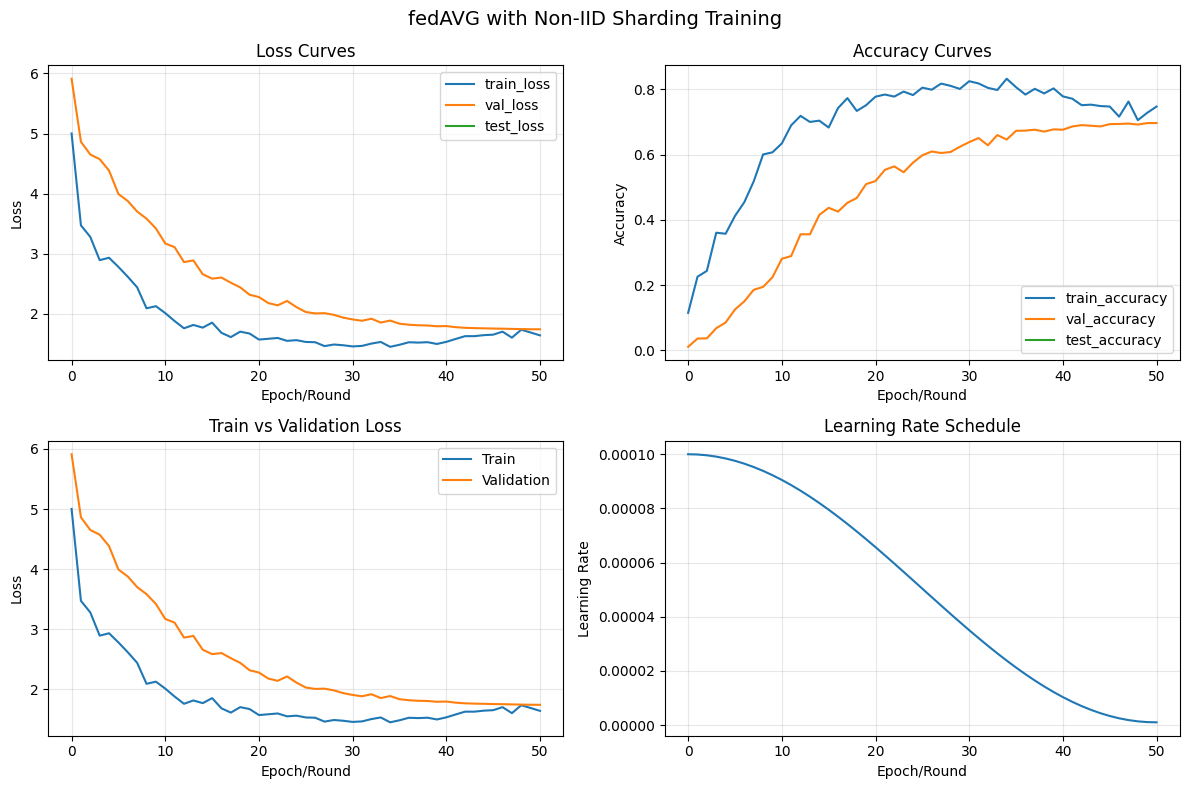

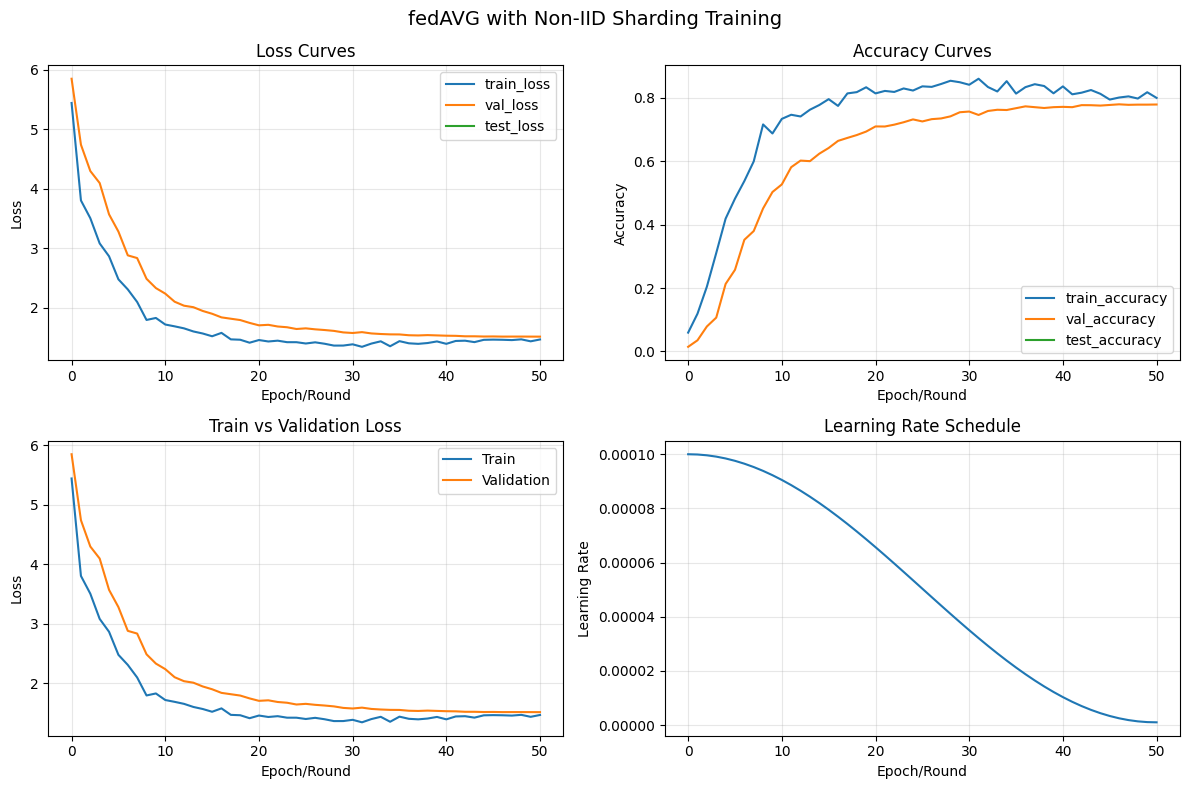

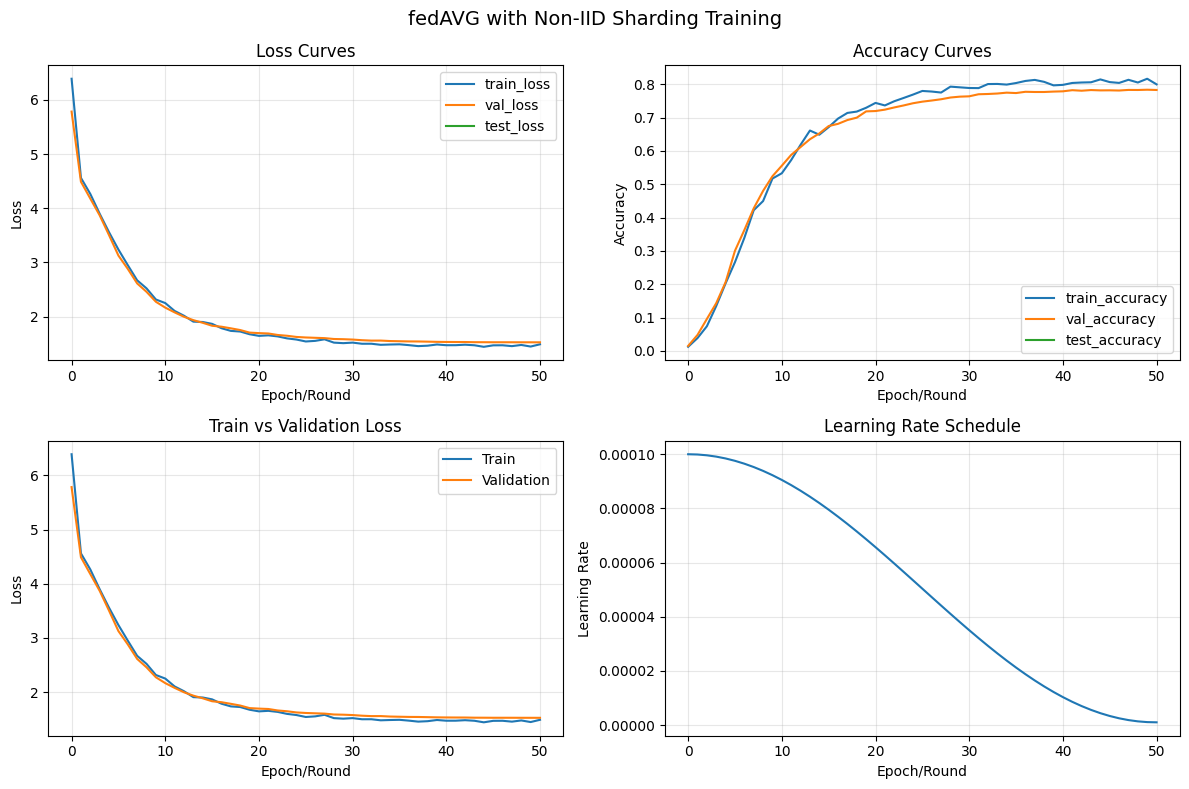

In [5]:
# Test different levels of data heterogeneity
noniid_results = {}

for nc in CONFIG['nc_values']:
    print(f"\n{'='*50}")
    print(f"Testing Nc = {nc} classes per client")
    print(f"{'='*50}")
    
    set_seed(CONFIG['seed'])
    model = create_dino_vit(num_classes=100, device=CONFIG['device'])
    
    config = {
        'num_clients': CONFIG['num_clients'],
        'participation_rate': CONFIG['participation_rate'],
        'local_steps': CONFIG['local_steps'],
        'num_rounds': CONFIG['num_rounds'],
        'learning_rate': CONFIG['federated_lr'],
        'momentum': 0.9,
        'weight_decay': 1e-6,
        'early_stopping_patience': 20,
        'batch_size': CONFIG['batch_size'],
        'checkpoint_dir': CONFIG['checkpoint_dir'],
        'log_dir': CONFIG['log_dir'],
        'seed': CONFIG['seed'],
        'sharding': {'strategy': 'non_iid', 'nc': nc}
    }
    
    trainer = FederatedTrainer(
        model=model,
        train_dataset=train_dataset,
        val_loader=val_loader,
        test_loader=test_loader,
        config=config,
        device=CONFIG['device'],
        experiment_name=f'fedavg_noniid_nc{nc}'
    )
    
    results = trainer.train(resume=False)
    noniid_results[nc] = results['accuracy']
    print(f"Nc={nc}: Test Accuracy = {results['accuracy']:.4f}")
    # Plot training curves
    plot_training_curves(
        trainer.get_metrics_history(),
        title='fedAVG with Non-IID Sharding Training',
        save_path=f"{CONFIG['log_dir']}/NonIID_curves_nc_{nc}.png"
    )

In [6]:
print("\nHeterogeneity Experiment Results:")
print("-" * 30)
for nc, acc in noniid_results.items():
    print(f"Nc = {nc}: {acc:.4f}")


Heterogeneity Experiment Results:
------------------------------
Nc = 5: 0.7001
Nc = 10: 0.7744
Nc = 50: 0.7783


## Experiment 4: Sparse Fine-tuning (Task Arithmetic)

In [6]:
# Federated sparse fine-tuning with least-sensitive masking
set_seed(CONFIG['seed'])
model = create_dino_vit(num_classes=100, device=CONFIG['device'])

sparse_config = {
    'num_clients': CONFIG['num_clients'],
    'participation_rate': CONFIG['participation_rate'],
    'local_steps': CONFIG['local_steps'],
    'num_rounds': CONFIG['num_rounds'],
    'learning_rate': CONFIG['federated_lr'],
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'batch_size': CONFIG['batch_size'],
    'checkpoint_dir': CONFIG['checkpoint_dir'],
    'log_dir': CONFIG['log_dir'],
    'seed': CONFIG['seed'],
    'sharding': {'strategy': 'iid', 'nc': 100},
    'sparse': {
        'sparsity_ratio': CONFIG['sparsity_ratio'],
        'calibration_rounds': CONFIG['calibration_rounds'],
        'mask_strategy': 'least_sensitive',
        'fisher_samples': CONFIG['fisher_samples']
    }
}

trainer = FederatedSparseTrainer(
    model=model,
    train_dataset=train_dataset,
    val_loader=val_loader,
    test_loader=test_loader,
    config=sparse_config,
    device=CONFIG['device'],
    experiment_name='fedavg_sparse_least_sensitive'
)

sparse_results = trainer.train(resume=True, calibrate_masks=True)
print(f"\nSparse Fine-tuning Test Accuracy: {sparse_results['accuracy']:.4f}")

Using cache found in /home/fabio/.cache/torch/hub/facebookresearch_dino_main


2026-01-29 04:24:37,526 | INFO | Sharding statistics:
2026-01-29 04:24:37,527 | INFO |   - Samples per client: 450.0 ± 0.0
2026-01-29 04:24:37,527 | INFO |   - Classes per client: 99.0 ± 0.9
2026-01-29 04:24:37,527 | INFO | Federated Learning Setup:
2026-01-29 04:24:37,528 | INFO |   - Total clients (K): 100
2026-01-29 04:24:37,528 | INFO |   - Participation rate (C): 0.1
2026-01-29 04:24:37,528 | INFO |   - Clients per round: 10
2026-01-29 04:24:37,528 | INFO |   - Local steps (J): 4
2026-01-29 04:24:37,528 | INFO |   - Learning rate: 0.0001 (scheduler: cosine)
2026-01-29 04:24:37,528 | INFO |   - Sharding: iid
2026-01-29 04:24:37,528 | INFO |   - Mixed precision (AMP): True
2026-01-29 04:24:37,528 | INFO |   - Early stopping patience: 100 rounds
2026-01-29 04:24:37,529 | INFO | Sparse Fine-tuning Setup:
2026-01-29 04:24:37,529 | INFO |   - Sparsity ratio: 0.9
2026-01-29 04:24:37,529 | INFO |   - Calibration rounds: 5
2026-01-29 04:24:37,529 | INFO |   - Mask strategy: least_sensitive

/home/fabio/Scrivania/PoliTo/II/Advanced/Vito's repo/amlproject/src/training/federated.py:113: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if self.use_amp else None


Calibration round 1/5


Computing Fisher:  10%|█         | 8/79 [00:02<00:21,  3.37it/s]


Calibration round 2/5


Computing Fisher:  10%|█         | 8/79 [00:01<00:17,  4.07it/s]


Calibration round 3/5


Computing Fisher:  10%|█         | 8/79 [00:01<00:17,  4.08it/s]


Calibration round 4/5


Computing Fisher:  10%|█         | 8/79 [00:01<00:17,  4.07it/s]


Calibration round 5/5


Computing Fisher:  10%|█         | 8/79 [00:01<00:17,  4.05it/s]


2026-01-29 04:24:48,408 | INFO | Mask calibration complete:
2026-01-29 04:24:48,409 | INFO |   - Global sparsity: 0.9000
2026-01-29 04:24:48,409 | INFO |   - Trainable params: 2,170,417
2026-01-29 04:24:48,409 | INFO |   - Masked params: 19,533,747
2026-01-29 04:24:48,410 | INFO | Starting federated training for 500 rounds


Round 0:   0%|          | 0/10 [00:00<?, ?it/s]/home/fabio/Scrivania/PoliTo/II/Advanced/Vito's repo/amlproject/src/training/federated_sparse.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


2026-01-29 04:25:00,494 | INFO | Step 0 | train_loss: 6.3532 | train_acc: 0.0148 | val_loss: 5.8026 | val_acc: 0.0138 | lr: 0.0001
2026-01-29 04:25:00,682 | INFO | Round 0: New best val accuracy: 0.0138


KeyboardInterrupt: 

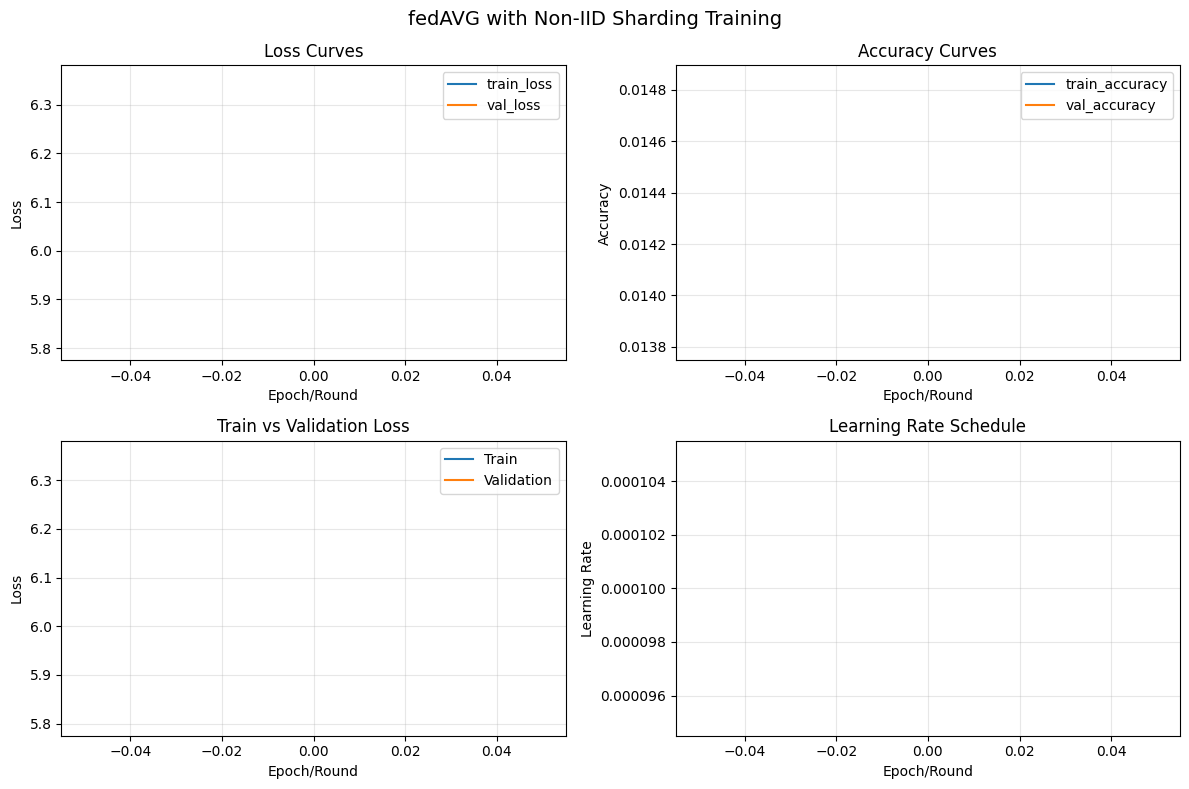

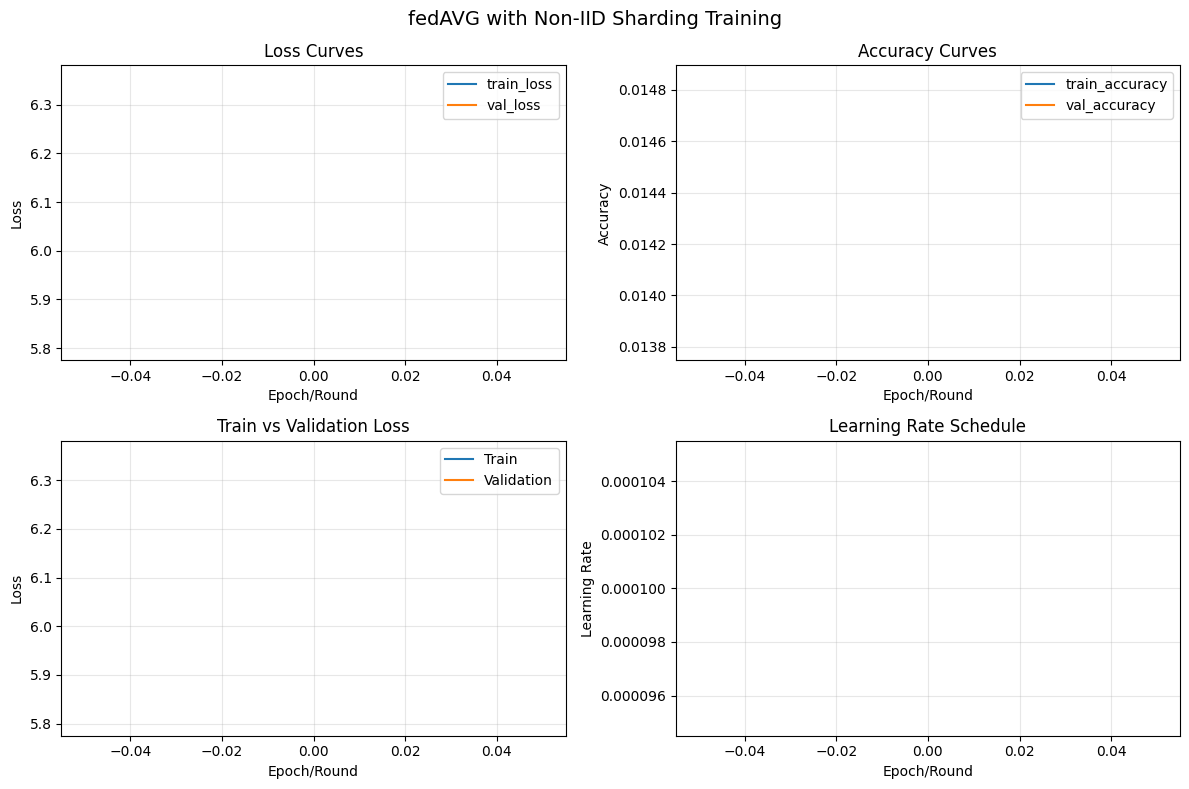

In [ ]:
# Plot training curves
plot_training_curves(
    trainer.get_metrics_history(),
    title='Sparse Fine-tuning (Task Arithmetic) Training',
    save_path=f"{CONFIG['log_dir']}/sparse_curves_.png"
)

## Experiment 5 (Extension): Mask Strategy Comparison

In [ ]:
# Compare all mask strategies
strategies = [
    'least_sensitive',
    'most_sensitive',
    'lowest_magnitude',
    'highest_magnitude',
    'random'
]

strategy_results = {}

for strategy in strategies:
    print(f"\n{'='*50}")
    print(f"Testing strategy: {strategy}")
    print(f"{'='*50}")
    
    set_seed(CONFIG['seed'])
    model = create_dino_vit(num_classes=100, device=CONFIG['device'])
    
    config = sparse_config.copy()
    config['sparse'] = {
        'sparsity_ratio': CONFIG['sparsity_ratio'],
        'calibration_rounds': CONFIG['calibration_rounds'],
        'mask_strategy': strategy,
        'fisher_samples': CONFIG['fisher_samples']
    }
    
    trainer = FederatedSparseTrainer(
        model=model,
        train_dataset=train_dataset,
        val_loader=val_loader,
        test_loader=test_loader,
        config=config,
        device=CONFIG['device'],
        experiment_name=f'fedavg_sparse_{strategy}'
    )
    
    results = trainer.train(resume=True, calibrate_masks=True)
    strategy_results[strategy] = results['accuracy']
    print(f"{strategy}: Test Accuracy = {results['accuracy']:.4f}")

In [ ]:
print("\nMask Strategy Comparison:")
print("="*60)
for strategy, acc in sorted(strategy_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{strategy:25s}: {acc:.4f}")

plot_comparison(
    {s: {'test_accuracy': a} for s, a in strategy_results.items()},
    metric='test_accuracy',
    title='Mask Strategy Comparison',
    save_path=f"{CONFIG['log_dir']}/strategy_comparison.png"
)

## Summary of Results

In [ ]:
print("EXPERIMENT SUMMARY")
print("="*60)

print(f"\n1. Centralized Baseline: {centralized_results['accuracy']:.4f}")
print(f"\n2. FedAvg (IID): {fedavg_iid_results['accuracy']:.4f}")

print("\n3. FedAvg (Non-IID):")
for nc, acc in noniid_results.items():
    print(f"   Nc={nc}: {acc:.4f}")

print(f"\n4. Sparse Fine-tuning: {sparse_results['accuracy']:.4f}")

print("\n5. Mask Strategy Comparison:")
for strategy, acc in sorted(strategy_results.items(), key=lambda x: x[1], reverse=True):
    print(f"   {strategy}: {acc:.4f}")

In [ ]:
# Save results to JSON
import json

all_results = {
    'centralized': centralized_results['accuracy'],
    'fedavg_iid': fedavg_iid_results['accuracy'],
    'fedavg_noniid': noniid_results,
    'sparse': sparse_results['accuracy'],
    'mask_strategies': strategy_results
}

with open(f"{CONFIG['log_dir']}/all_results.json", 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"Results saved to {CONFIG['log_dir']}/all_results.json")